In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vlsp-sentiment/datasets/vlsp_sentiment_test.csv
/kaggle/input/vlsp-sentiment/datasets/vi-model-CBOW.bin
/kaggle/input/vlsp-sentiment/datasets/vlsp_sentiment_train.csv


In [25]:
!pip install pyvi

In [77]:
# ==== IMPORT THƯ VIỆN ====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import digits
from pyvi import ViTokenizer
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, Embedding, Conv2D, MaxPool2D, LSTM, Dense, Dropout, concatenate, Layer, Reshape, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from gensim.models import KeyedVectors

# ==== THIẾT LẬP SIÊU THAM SỐ ====
MAX_FEATURES = 10000
MAXLEN = 300
BATCH_SIZE = 64
EMBEDDING_DIM = 400
NB_EPOCH = 30

In [27]:
# ==== TIỀN XỬ LÝ DỮ LIỆU ====
def load_data(path="/kaggle/input/vlsp-sentiment/datasets"):
    train_df = pd.read_csv(f"{path}/vlsp_sentiment_train.csv", sep='\t')
    train_df.columns = ['Class', 'Text']
    test_df = pd.read_csv(f"{path}/vlsp_sentiment_test.csv", sep='\t')
    test_df.columns = ['Class', 'Text']

    def encode_label(label):
        return [1, 0, 0] if label == -1 else [0, 1, 0] if label == 0 else [0, 0, 1]

    y_train = np.array([encode_label(lbl) for lbl in train_df['Class']])
    y_test = np.array([encode_label(lbl) for lbl in test_df['Class']])

    def preprocess(text):
        text = ''.join([ch for ch in text if ch not in digits])
        return ViTokenizer.tokenize(text.lower()).split()

    train_tokens = [preprocess(text) for text in train_df['Text']]
    test_tokens = [preprocess(text) for text in test_df['Text']]

    tokenizer = Tokenizer(num_words=MAX_FEATURES)
    tokenizer.fit_on_texts(train_tokens)

    X_train = pad_sequences(tokenizer.texts_to_sequences(train_tokens), maxlen=MAXLEN)
    X_test = pad_sequences(tokenizer.texts_to_sequences(test_tokens), maxlen=MAXLEN)

    return X_train, y_train, X_test, y_test, tokenizer.word_index

In [28]:
# ==== TẠO EMBEDDING TỪ WORD2VEC ====
def create_embedding_layer(word_index, pretrained_path, embedding_dim=400, max_vocab_size=10000, trainable=True):
    print(f"→ Loading Word2Vec từ: {pretrained_path}")
    word_vectors = KeyedVectors.load_word2vec_format(pretrained_path, binary=True)

    vocab_size = min(len(word_index) + 1, max_vocab_size)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    oov_count = 0
    for word, i in word_index.items():
        if i < max_vocab_size:
            try:
                embedding_matrix[i] = word_vectors[word]
            except KeyError:
                embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)
                oov_count += 1

    print(f"→ Số từ OOV: {oov_count}/{len(word_index)}")

    return Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim,
                     weights=[embedding_matrix],
                     input_length=MAXLEN,
                     trainable=trainable)

In [29]:
# ==== ATTENTION LAYER (giữ nguyên) ====
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.squeeze(ait, -1)
        ait = tf.nn.softmax(ait)
        ait = tf.expand_dims(ait, -1)
        weighted_input = x * ait
        return tf.reduce_sum(weighted_input, axis=1)

In [41]:
from keras.regularizers import l2
from keras.layers import Lambda

# ==== MÔ HÌNH ====
def build_model(embedding_layer, reg_lambda=0.01):
    input_layer = Input(shape=(MAXLEN,))
    x = embedding_layer(input_layer)
    x = Lambda(lambda x: tf.expand_dims(x, axis=-1))(x)  # (batch_size, MAXLEN, EMBEDDING_DIM, 1)

    pooled_outputs = []
    filter_sizes = [3, 4, 5]
    num_filters = 128

    for fsz in filter_sizes:
        conv = Conv2D(filters=num_filters,
                      kernel_size=(fsz, EMBEDDING_DIM),
                      activation='relu',
                      kernel_regularizer=l2(reg_lambda))(x)
        pool = MaxPool2D(pool_size=(MAXLEN - fsz + 1, 1))(conv)
        pooled_outputs.append(pool)

    merged = concatenate(pooled_outputs, axis=-1)  # (batch, 1, 1, num_filters * len(filter_sizes))
    merged = Reshape((len(filter_sizes), num_filters))(merged)  # (batch, timesteps=3, features=128)
    drop = Dropout(0.3)(merged)

    lstm_out = Bidirectional(
        LSTM(100,
             return_sequences=True,
             kernel_regularizer=l2(reg_lambda),
             recurrent_regularizer=l2(reg_lambda)
        )
    )(drop)

    attention_out = AttentionLayer()(lstm_out)  # (batch, 200)
    x = Dense(100, activation='relu', kernel_regularizer=l2(reg_lambda))(attention_out)
    x = Dropout(0.3)(x)
    output = Dense(3, activation='softmax', kernel_regularizer=l2(reg_lambda))(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # print(model.evaluate())
    return model


In [32]:
# ==== BIỂU ĐỒ LOSS & ACC ====
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy theo Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss theo Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==== MA TRẬN NHẦM LẪN ====
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    labels = ['Negative', 'Neutral', 'Positive']
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), target_names=labels))


In [34]:
# ==== HUẤN LUYỆN & ĐÁNH GIÁ ====
def train_and_evaluate(pretrained_path):
    X_train, y_train, X_test, y_test, word_index = load_data()
    embedding_layer = create_embedding_layer(word_index, pretrained_path)

    model = build_model(embedding_layer)

    print("→ Bắt đầu huấn luyện...")
    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=NB_EPOCH,
                        validation_data=(X_test, y_test),
                        shuffle=True)

    print("→ Đánh giá trên tập test:")
    score, acc = model.evaluate(X_test, y_test)
    print("✅ Test Accuracy:", acc)

    y_pred = model.predict(X_test)
    plot_loss_accuracy(history)
    plot_confusion_matrix(y_test, y_pred)

In [75]:
from keras.regularizers import l2
from keras.layers import Lambda
def build_model(embedding_layer, reg_lambda=0.01):
    input_layer = Input(shape=(MAXLEN,))
    x = embedding_layer(input_layer)
    # x = tf.expand_dims(x, axis=-1)  # shape: (batch_size, MAXLEN, EMBEDDING_DIM, 1)
    x = Lambda(lambda x: tf.expand_dims(x, axis=-1))(x)
    pooled_outputs = []
    filter_sizes = [3, 4, 5]
    num_filters = 128

    for fsz in filter_sizes:
        conv = Conv2D(filters=num_filters,
                      kernel_size=(fsz, EMBEDDING_DIM),
                      activation='relu',
                      kernel_regularizer=l2(reg_lambda))(x)
        pool = MaxPool2D(pool_size=(MAXLEN - fsz + 1, 1))(conv)
        pooled_outputs.append(pool)

    merged = concatenate(pooled_outputs, axis=-1)
    merged = tf.keras.layers.Reshape((num_filters * len(filter_sizes),))(merged)
    drop = Dropout(0.5)(merged)
    reshaped = tf.keras.layers.Reshape((1, num_filters * len(filter_sizes)))(drop)

    # LSTM with regularization
    lstm_out = LSTM(100,
                return_sequences=False,
                kernel_regularizer=l2(reg_lambda),
                recurrent_regularizer=l2(reg_lambda)
)(reshaped)

    output = Dense(3, activation='softmax', kernel_regularizer=l2(reg_lambda))(lstm_out)


    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

→ Loading Word2Vec từ: /kaggle/input/vlsp-sentiment/datasets/vi-model-CBOW.bin
→ Số từ OOV: 1214/7918
→ Bắt đầu huấn luyện...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.4512 - loss: 4.2588 - val_accuracy: 0.5914 - val_loss: 1.5774
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.6139 - loss: 1.4473 - val_accuracy: 0.6457 - val_loss: 1.2065
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6764 - loss: 1.1582 - val_accuracy: 0.6533 - val_loss: 1.1571
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6934 - loss: 1.0862 - val_accuracy: 0.6848 - val_loss: 1.1258
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.7340 - loss: 1.0432 - val_accuracy: 0.6467 - val_loss: 1.1404
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7404 - loss: 1.0161 - val_accuracy: 0.6648 - val_loss: 1.0909
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7648 - loss: 0.9774 - val_accuracy: 0.6886 - val_loss: 1.0998
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7745 - loss: 0.9426 - val_accuracy: 0.6962 - v

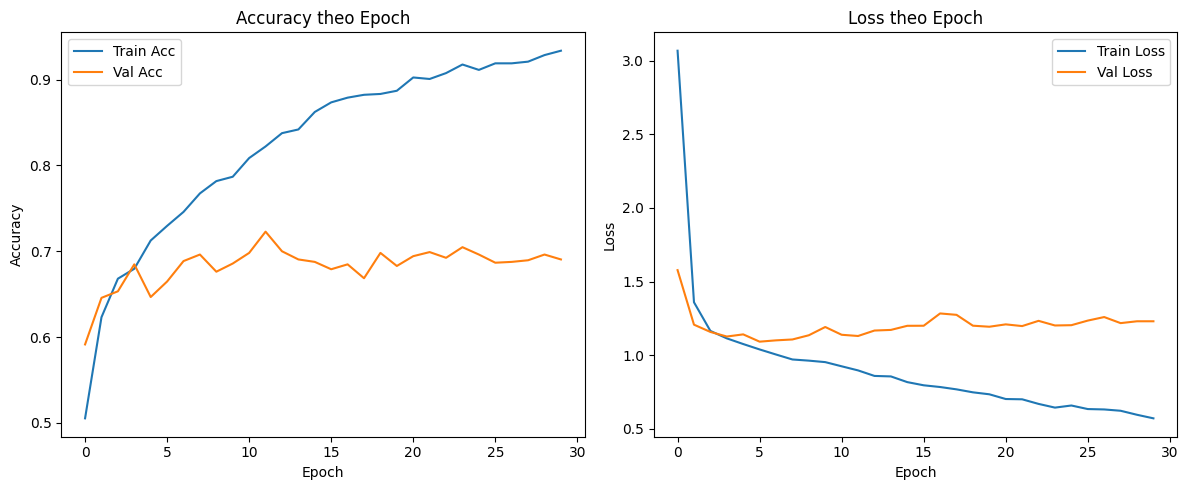

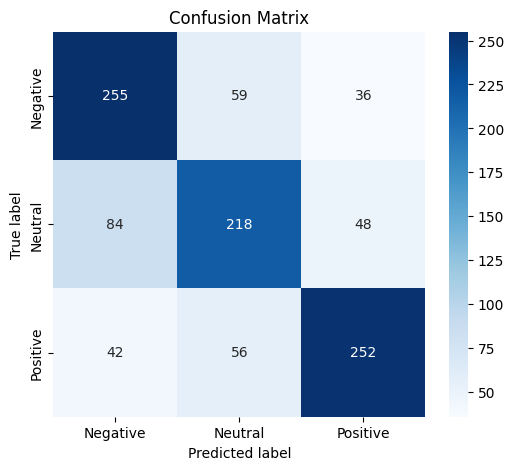


Classification Report:

              precision    recall  f1-score   support

    Negative       0.67      0.73      0.70       350
     Neutral       0.65      0.62      0.64       350
    Positive       0.75      0.72      0.73       350

    accuracy                           0.69      1050
   macro avg       0.69      0.69      0.69      1050
weighted avg       0.69      0.69      0.69      1050



In [78]:
pretrained_path = "/kaggle/input/vlsp-sentiment/datasets/vi-model-CBOW.bin"
train_and_evaluate(pretrained_path)

→ Loading Word2Vec từ: /kaggle/input/vlsp-sentiment/datasets/vi-model-CBOW.bin
→ Số từ OOV: 1214/7918


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_28 (Embedding)  │ (None, 300, 400)       │      3,167,600 │ input_layer_28[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_18 (Lambda)        │ (None, 300, 400, 1)    │              0 │ embedding_28[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 298, 1, 128)    │        153,728 │ lambda_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 297, 1, 128)    │        204,928 │ lambda_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 296, 1, 128)    │        256,128 │ lambda_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_52          │ (None, 1, 1, 128)      │              0 │ conv2d_52[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_53          │ (None, 1, 1, 128)      │              0 │ conv2d_53[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_54          │ (None, 1, 1, 128)      │              0 │ conv2d_54[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 1, 1, 384)      │              0 │ max_pooling2d_52[0][0… │
│ (Concatenate)             │                        │                │ max_pooling2d_53[0][0… │
│                           │                        │                │ max_pooling2d_54[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_30 (Reshape)      │ (None, 384)            │              0 │ concatenate_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 384)            │              0 │ reshape_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_31 (Reshape)      │ (None, 1, 384)         │              0 │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_19 (LSTM)            │ (None, 100)            │        194,000 │ reshape_31[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 3)              │            303 │ lstm_19[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,976,687 (15.17 MB)

 Trainable params: 3,976,687 (15.17 MB)

 Non-trainable params: 0 (0.00 B)

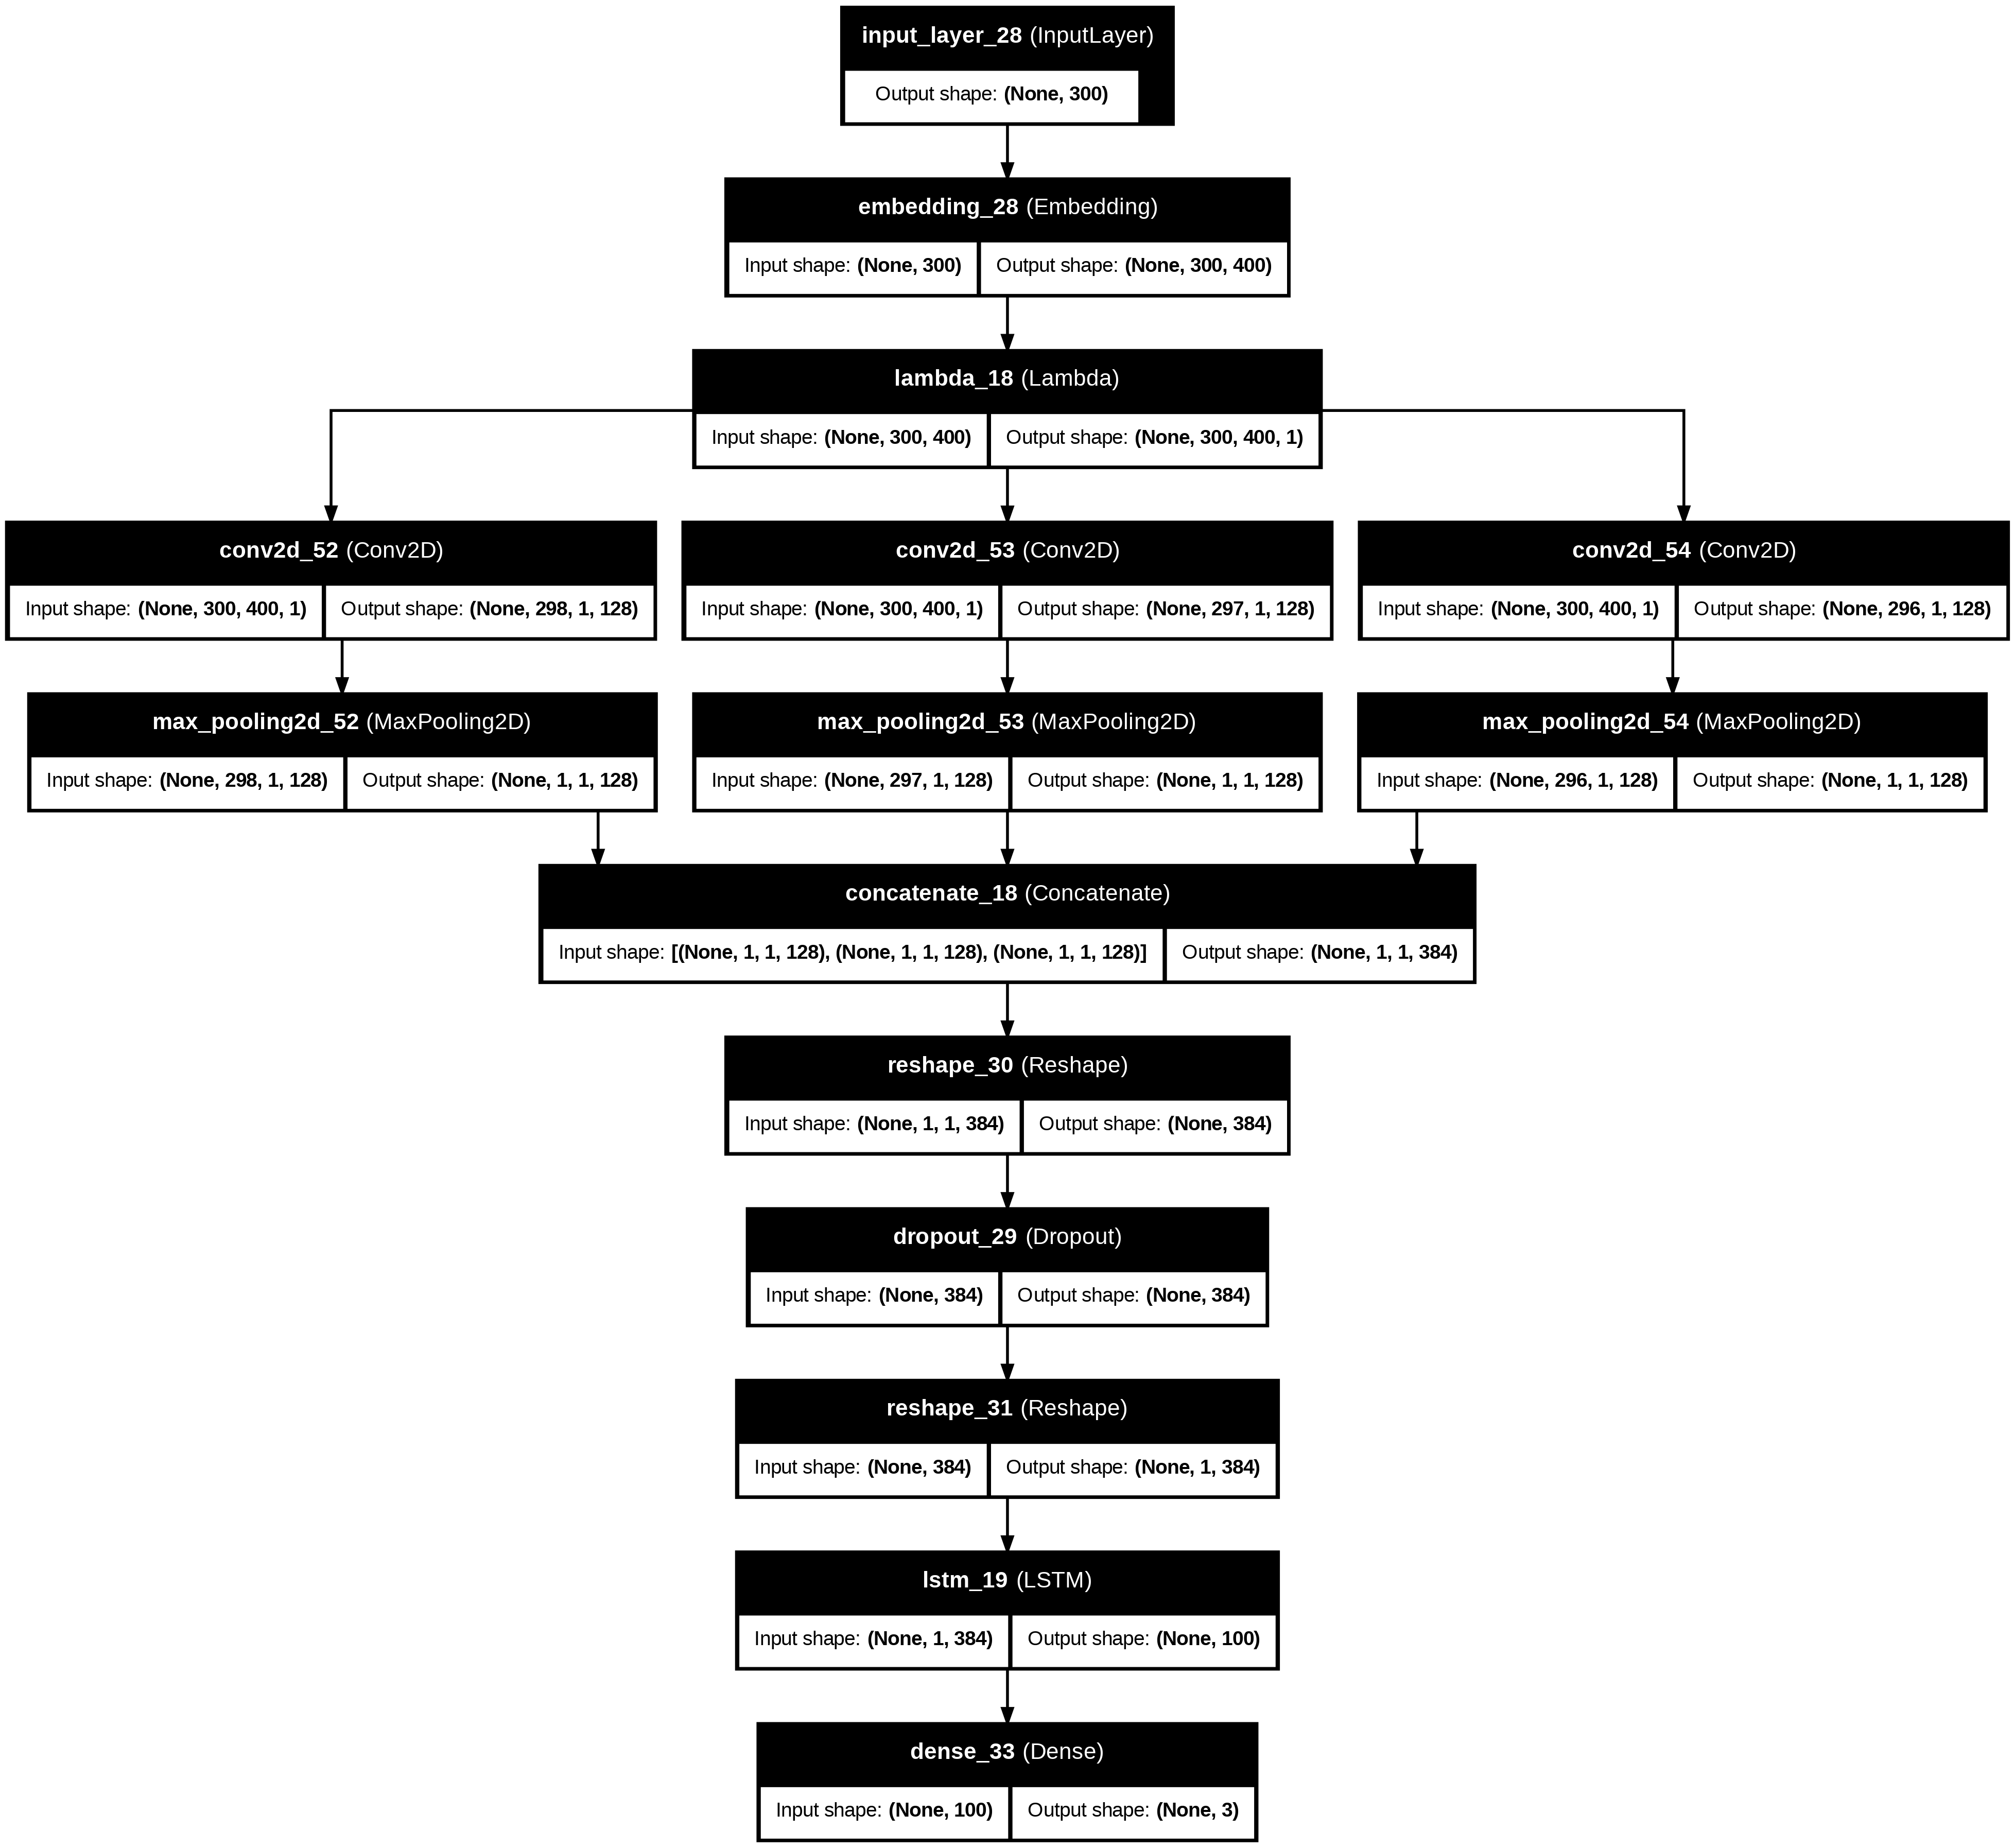

In [80]:
from keras.utils import plot_model
X_train, y_train, X_test, y_test, word_index = load_data()
embedding_layer = create_embedding_layer(word_index, pretrained_path)

model = build_model(embedding_layer)
model.summary()
# model là đối tượng Keras model đã build sẵn
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
